# Sesión 10: Word2Vec

---

Viernes 27 de Octubre de 2023

## Funcionamiento interno de convertir palabras a vectores utilizando skip-gram's

In [1]:
import io
import re
import string
import tqdm # for progress bar

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
SEED = 42   # Declaramos una semilla para que los resultados sean reproducibles
AUTOTUNE = tf.data.AUTOTUNE # AUTOTUNE nos permite que TensorFlow seleccione automáticamente el número de hilos de procesamiento que se utilizarán para ejecutar la operación

### Tokenización

In [3]:
sentence = "The wide road shimmered in the hot sun"
tokens = list(sentence.lower().split()) # Convertimos la frase en una lista de tokens
print(len(tokens), tokens)

8 ['the', 'wide', 'road', 'shimmered', 'in', 'the', 'hot', 'sun']


In [4]:
# Creamos un diccionario de vocabulario
vocab, index = {}, 1 # Inicializamos el índice en 1 en lugar de 0
vocab['pad'] = 0 # Agregamos el token de relleno (padding)

for token in tokens:
  if token not in vocab:
    vocab[token] = index
    index += 1

vocab_size = len(vocab)
print(vocab)

{'pad': 0, 'the': 1, 'wide': 2, 'road': 3, 'shimmered': 4, 'in': 5, 'hot': 6, 'sun': 7}


In [5]:
# Creamos un diccionario inverso, que nos permitirá convertir los índices en palabras
inverse_vocab = {index: token for token, index in vocab.items()}
print(inverse_vocab)

{0: 'pad', 1: 'the', 2: 'wide', 3: 'road', 4: 'shimmered', 5: 'in', 6: 'hot', 7: 'sun'}


In [6]:
# Reconstruimos la frase a partir de los índices (para comprobar que todo funciona correctamente)
example_sequence = [vocab[word] for word in tokens]
print(example_sequence) # Oración convertida en una secuencia de índices

[1, 2, 3, 4, 5, 1, 6, 7]


### Generación de skip-grams

In [7]:
window_size = 2
positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
      example_sequence, 
      vocabulary_size=vocab_size,
      window_size=window_size,
      negative_samples=0) # negative_samples=0 significa que no se muestrean ejemplos negativos

print(len(positive_skip_grams))

for target, context in positive_skip_grams[:5]:
  print(f"({target}, {context}): ({inverse_vocab[target]}, {inverse_vocab[context]})")

26
(5, 1): (in, the)
(6, 5): (hot, in)
(2, 4): (wide, shimmered)
(7, 1): (sun, the)
(3, 1): (road, the)


### Generar muestras negativas

In [8]:
target_word, context_word = positive_skip_grams[0]
num_ns = 4 # Número de muestras negativas por cada ejemplo positivo

context_class = tf.reshape(tf.constant(context_word, dtype="int64"), (1, 1))

negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
    true_classes = context_class, # clase positiva
    num_true = 1, # número de clases positivas
    num_sampled = num_ns, # número de muestras negativas
    unique = True, # todas las muestras negativas deben ser únicas
    range_max = vocab_size, # rango de valores enteros
    seed = SEED, # semilla para reproducibilidad
    name = "negative_sampling" # nombre de la operación
)

print(negative_sampling_candidates)
print([inverse_vocab[index.numpy()] for index in negative_sampling_candidates])

tf.Tensor([2 1 4 3], shape=(4,), dtype=int64)
['wide', 'the', 'shimmered', 'road']


Funcionamiento interno de la tokenización y generación de muestras negativas

In [9]:
# Concatenación de muestras positivas y negativas

squeezed_context_class = tf.squeeze(context_class, 1) # Eliminamos las dimensiones de tamaño 1 de la forma de un tensor
context = tf.concat([squeezed_context_class, negative_sampling_candidates], 0) # Concatenamos las muestras positivas y negativas
label = tf.constant([1] + [0]*num_ns, dtype="int64") # Creamos las etiquetas correspondientes
target = target_word # Definimos el objetivo

print(f"target_index    : {target}") # Índice de la palabra objetivo
print(f"target_word     : {inverse_vocab[target_word]}") # Palabra objetivo
print(f"context_indices : {context}") # Índices de las palabras del contexto
print(f"context_words   : {[inverse_vocab[c.numpy()] for c in context]}") # Palabras del contexto
print(f"label           : {label}") # Etiqueta

target_index    : 5
target_word     : in
context_indices : [1 2 1 4 3]
context_words   : ['the', 'wide', 'the', 'shimmered', 'road']
label           : [1 0 0 0 0]


---

## Implementación de la red neuronal Word2Vec

### Función para generar de datos de entrenamiento

In [10]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  targets, contexts, labels = [], [], []

  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size) # Creamos una tabla de muestreo para muestrear palabras del vocabulario

  for sequence in tqdm.tqdm(sequences): # Iteramos sobre las secuencias

    # Generación de skip-grams positivos
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
        sequence, 
        vocabulary_size=vocab_size,
        sampling_table=sampling_table,
        window_size=window_size,
        negative_samples=0)
    
    # Generación de muestras negativas
    for target_word, context_word in positive_skip_grams:

      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1, 
          num_sampled=num_ns, 
          unique=True, 
          range_max=vocab_size, 
          seed=seed, 
          name="negative_sampling")
      
      # Concatenaciones y etiquetas
      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")
      

			# Añadimos los datos a las listas
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)
      
  return targets, contexts, labels

### Descargar documento (Text Corpus)

In [11]:
path_to_file = keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [12]:
text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool)) # Cargamos el dataset

### Estandarización

In [13]:
def custom_standardization(input_data): # Función para eliminar los signos de puntuación
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')

In [14]:
vocab_size = 4096 # Tamaño del vocabulario
sequence_length = 10 # Longitud de cada oración

vectorize_layer = keras.layers.TextVectorization(
    standardize=custom_standardization, # Función de estandarización
    max_tokens=vocab_size, # Tamaño del vocabulario
    output_mode='int', # Modo de salida
    output_sequence_length=sequence_length) # Longitud de cada secuencia

vectorize_layer.adapt(text_ds.batch(1024)) # Adaptamos el vectorizador al dataset

In [15]:
inverse_vocab = vectorize_layer.get_vocabulary() # Diccionario inverso
print(inverse_vocab[:20])

['', '[UNK]', 'the', 'and', 'to', 'i', 'of', 'you', 'my', 'a', 'that', 'in', 'is', 'not', 'for', 'with', 'me', 'it', 'be', 'your']


In [16]:
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch() # Vectorizamos el dataset

In [17]:
sequences = list(text_vector_ds.as_numpy_iterator()) # Convertimos el dataset en una lista de secuencias
print(len(sequences))

for seq in sequences[:5]:
  print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

32777
[ 89 270   0   0   0   0   0   0   0   0] => ['first', 'citizen', '', '', '', '', '', '', '', '']
[138  36 982 144 673 125  16 106   0   0] => ['before', 'we', 'proceed', 'any', 'further', 'hear', 'me', 'speak', '', '']
[34  0  0  0  0  0  0  0  0  0] => ['all', '', '', '', '', '', '', '', '', '']
[106 106   0   0   0   0   0   0   0   0] => ['speak', 'speak', '', '', '', '', '', '', '', '']
[ 89 270   0   0   0   0   0   0   0   0] => ['first', 'citizen', '', '', '', '', '', '', '', '']


### Generación de datos de entrenamiento

In [18]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,  # Secuencias de índices
    window_size=2, # Tamaño de la ventana
    num_ns=4, # Número de muestras negativas por cada ejemplo positivo
    vocab_size=vocab_size,  # Tamaño del vocabulario
    seed=SEED # Semilla para reproducibilidad
    )

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

# Comprobamos las dimensiones de los datos
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|██████████| 32777/32777 [00:04<00:00, 7304.29it/s]


targets.shape: (65072,)
contexts.shape: (65072, 5)
labels.shape: (65072, 5)


In [19]:
# Ordenamos los datos
BATCH_SIZE = 1024
BUFFER_SIZE = 10000

dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

print(dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [20]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE) # Cacheamos el dataset

### Definición del modelo de la red neuronal

In [21]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = tf.keras.layers.Embedding(vocab_size, 
                                                      embedding_dim,
                                                      input_length=1,
                                                      name="w2v_embedding", )  # Capa de embedding para las palabras objetivo
    self.context_embedding = tf.keras.layers.Embedding(vocab_size, 
                                                       embedding_dim, 
                                                       input_length=5)  # Capa de embedding para las palabras del contexto
    
  def call(self, pair):
    target, context = pair

    if len(target.shape) == 2: # Si el tensor tiene dos dimensiones
      target = tf.squeeze(target, axis=1) # Eliminamos la dimensión de tamaño 1

    word_emb = self.target_embedding(target) # Embedding de la palabra objetivo (target)
    context_emb = self.context_embedding(context)  # Embedding de las palabras del contexto

    dots = tf.einsum('be,bte->bt', word_emb, context_emb) # Producto punto entre las palabras del contexto y la palabra objetivo

    return dots

### Definimos la función de pérdida y compilamos el modelo

In [22]:
def custom_loss(x_logit, y_true): # Función de pérdida
  return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [23]:
embedding_dim = 128 # Dimensión del embedding
word2vec = Word2Vec(vocab_size, embedding_dim) # Instanciamos el modelo
word2vec.compile(optimizer='adam', 
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                 metrics=['accuracy']) # Compilamos el modelo

### Entrenamiento del modelo


In [24]:
word2vec.fit(dataset, epochs=20) # Entrenamos el modelo

Epoch 1/20
63/63 [==============================] - 1s 4ms/step - loss: 1.6082 - accuracy: 0.2367
Epoch 2/20
63/63 [==============================] - 0s 3ms/step - loss: 1.5890 - accuracy: 0.5565
Epoch 3/20
63/63 [==============================] - 0s 4ms/step - loss: 1.5414 - accuracy: 0.6069
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 1.4579 - accuracy: 0.5780
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 1.3588 - accuracy: 0.5845
Epoch 6/20
63/63 [==============================] - 0s 4ms/step - loss: 1.2614 - accuracy: 0.6109
Epoch 7/20
63/63 [==============================] - 0s 4ms/step - loss: 1.1705 - accuracy: 0.6452
Epoch 8/20
63/63 [==============================] - 0s 4ms/step - loss: 1.0863 - accuracy: 0.6791
Epoch 9/20
63/63 [==============================] - 0s 4ms/step - loss: 1.0081 - accuracy: 0.7117
Epoch 10/20
63/63 [==============================] - 0s 4ms/step - loss: 0.9355 - accuracy: 0.7406
Epoch 11/20
63/63 [

### Descargamos los pesos del modelo
Parar poder mostrar los resultados en tensorboard, es necesario descargar los pesos del modelo.

In [25]:
weight = word2vec.get_layer('w2v_embedding').get_weights()[0] # Obtenemos los pesos de la capa de embedding
vocab = vectorize_layer.get_vocabulary() # Obtenemos el vocabulario

# Guardamos los pesos y el vocabulario en un archivo
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')   # Archivo de vectores
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')  # Archivo de metadatos

# Retiramos el token de relleno (padding)
for index, word in enumerate(vocab):
  if index == 0: continue  # Omitimos el token de relleno
  vec = weight[index] # Obtenemos el vector de la palabra
  out_v.write('\t'.join([str(x) for x in vec]) + "\n") # Escribimos el vector en el archivo de vectores
  out_m.write(word + "\n") # Escribimos la palabra en el archivo de metadatos
out_v.close() # Cerramos el archivo de vectores
out_m.close() # Cerramos el archivo de metadatos

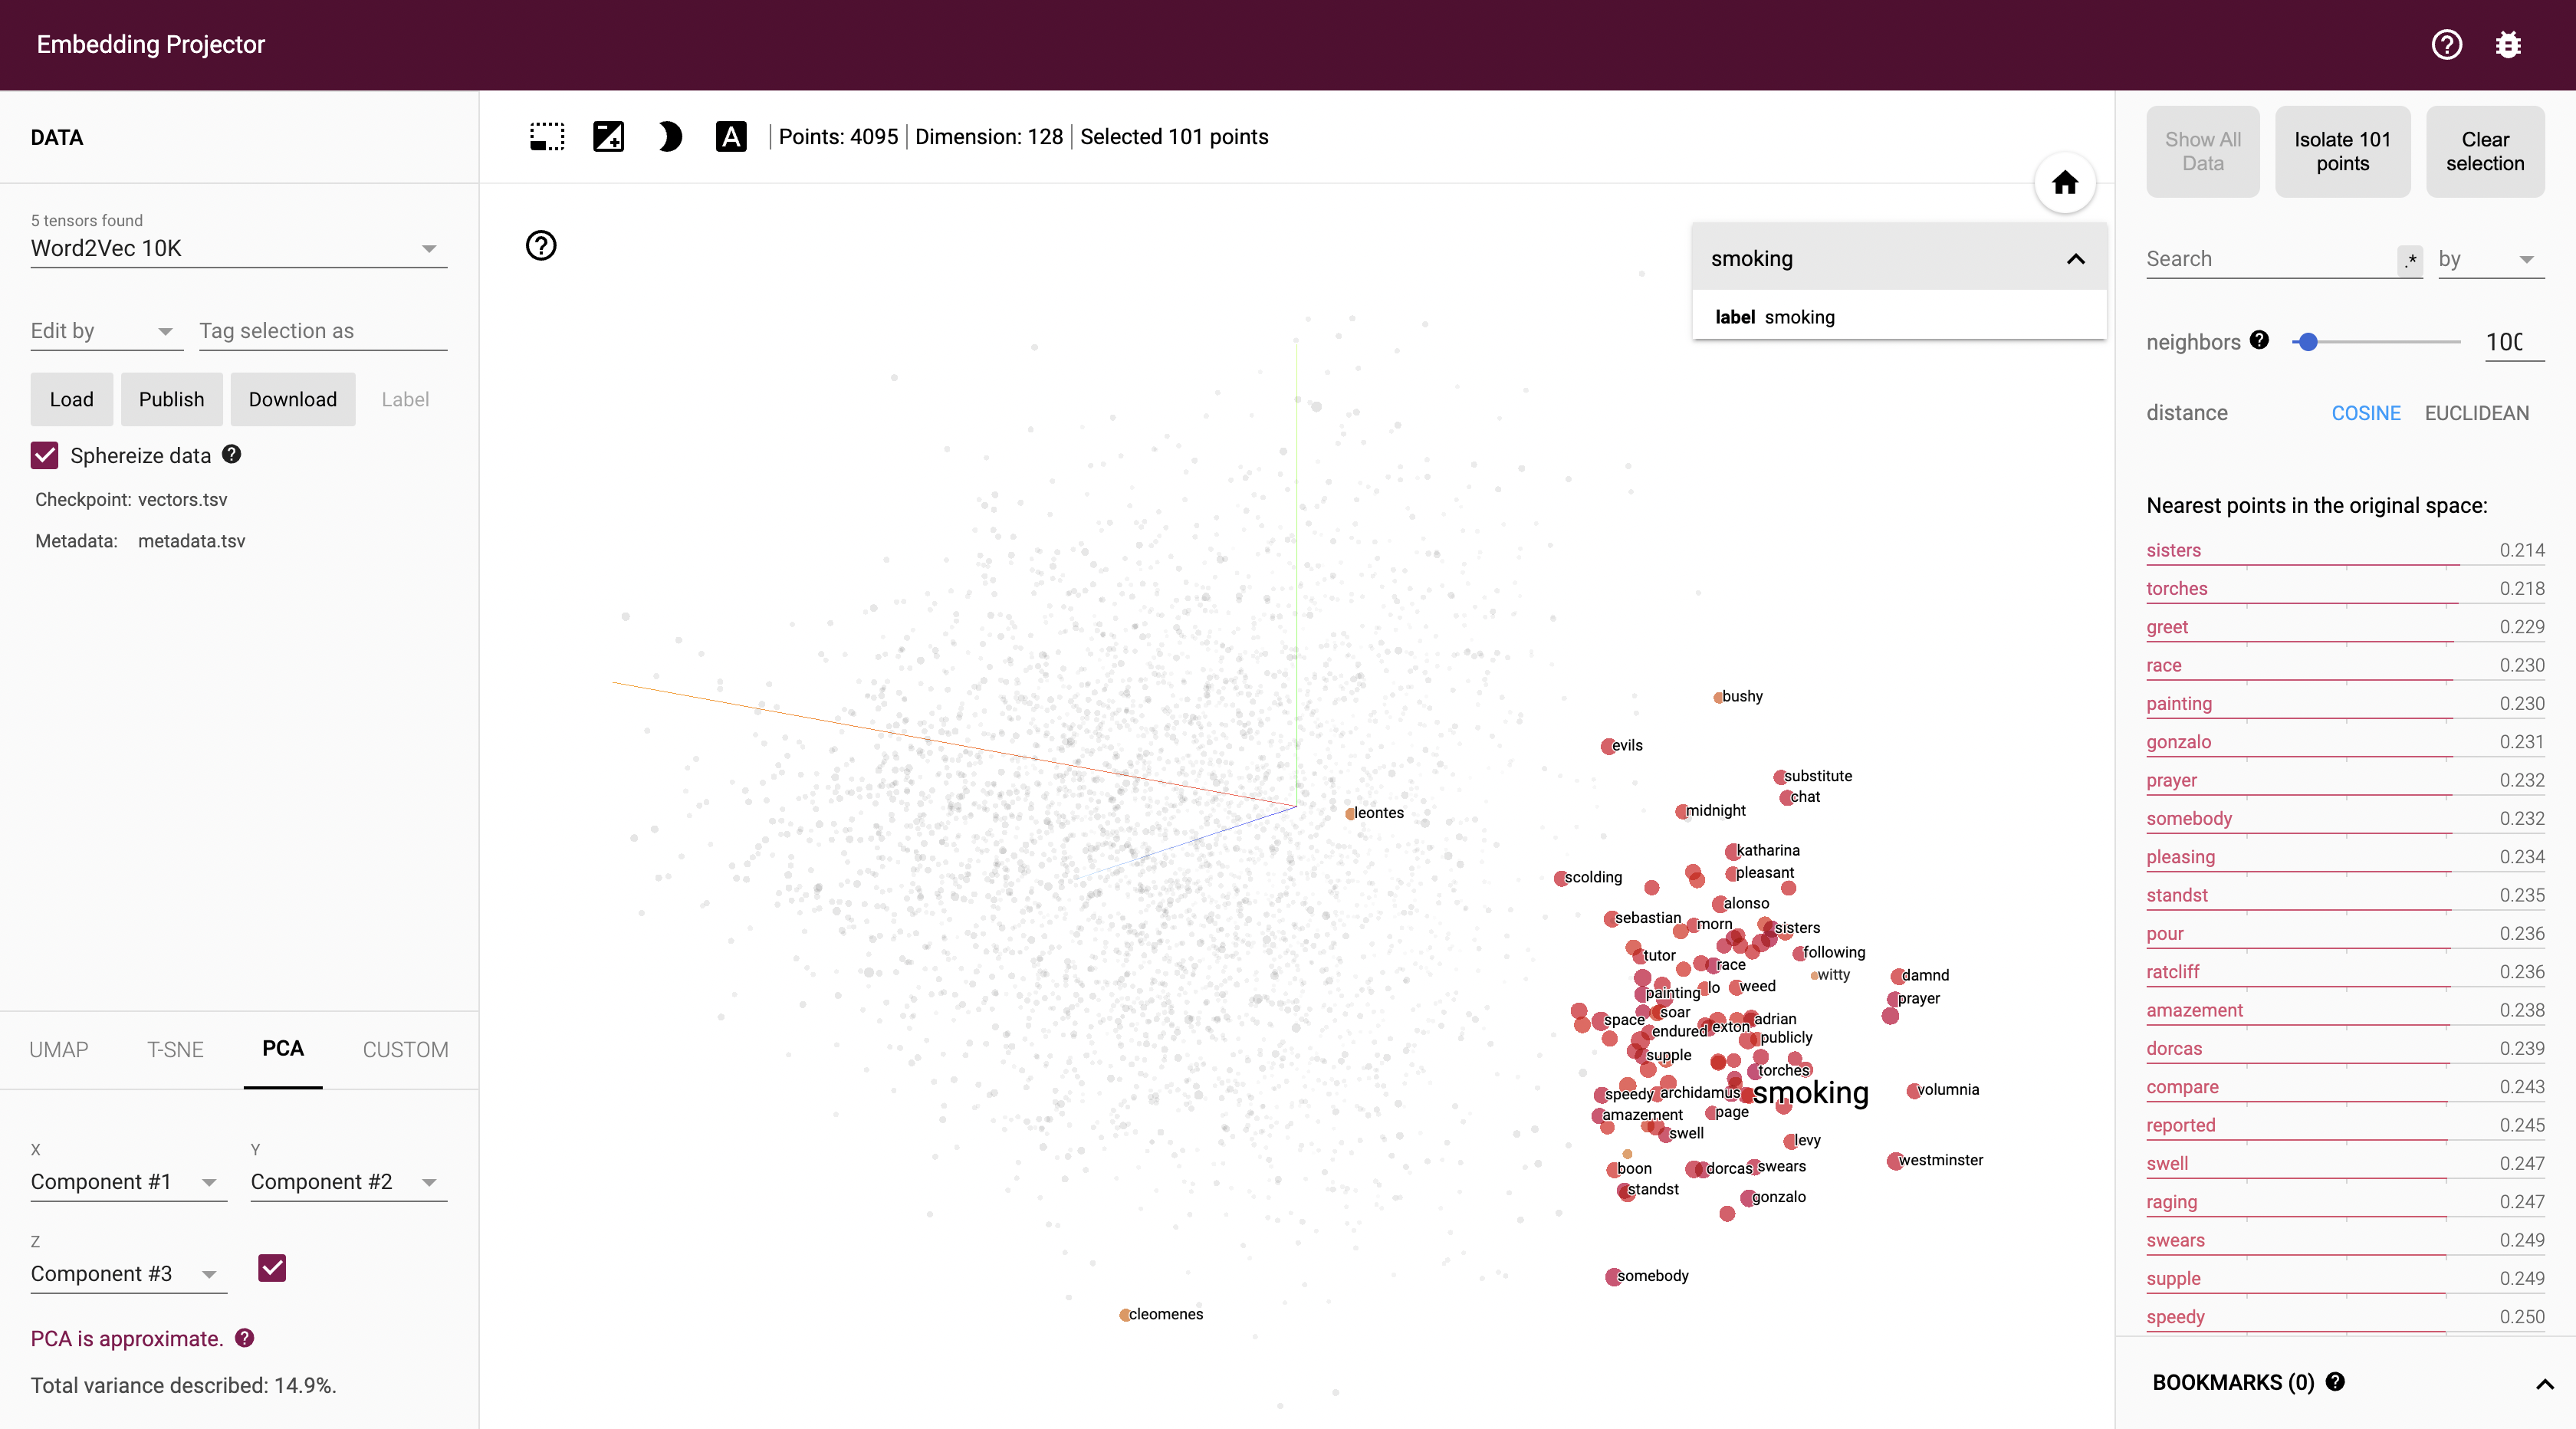